# Machine Learning & Experimentation

There is a proposed changed in ML implementation. Evidence needs to be gathered, and presented. This can be faciliated with Experimentation and Statistics.

In [2]:
import pandas as pd
from scipy import stats
import statsmodels.stats.api as sms
from statsmodels.stats.power import TTestIndPower
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# data vis styling settings
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# customizing the colors
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', ['#204FAB', '#bababa'])

import time

# reproducibility settings
random_state=42
np.random.seed(seed=random_state)

## Experimental Design:
- The null hypothesis (H<sub>0</sub>) is that there is no computation time difference between the two methods.
- The alternative hypothesis (H<sub>A</sub>) is that there _is_ a computation time difference between the two methods.

- We are following convention by setting p-value threshold to p-value = 0.05. In context, the p-value is just a numerical representation of how sensitive we are to false positives. If changing the code is not a huge investment of resources, then you can adjust the p-value to be less restrictive.

In [3]:
# testing different ways to transform data

def row_fcn(id_string):
    '''
    passing in numbers
    return the first digit of the number
    '''
    return int(str(id_string)[0])

def df_fcn(df, column):
    '''
    passing in dataframe and target column
    transforming the data to return the first digit of a number
    return dataframe with transformed column
    '''
    # case: passing in dataframes and returning a dataframe
    df[column] = df[column].apply(row_fcn)
    return df

NTS: check memory allocation for anonymous functions just for my own info

### Power Analysis

_with great power comes great responsibility_

To set up the experiment, we need to determine the minimum sample size needed to detect the minimum difference that we care about to make sure we dont have an underpowered experiment.

In [4]:
# baseline data
sample_deltas = []
for _ in range(10):
    fake_data = pd.DataFrame(np.random.randint(0, 100, 100)
                             , columns=['values'])
    start = time.process_time()
    fake_data = df_fcn(fake_data, 'values')
    delta = time.process_time() - start
    sample_deltas.append(delta)
    
np.mean(sample_deltas), np.std(sample_deltas)

(0.0019935999999999955, 0.000890361634393605)

Let's say that we're interested in a 1<sup>+</sup>% reduction in costs. This would translate into a huge reduction in money spend on cloud computation and the time needed to produce and iterate.

This means that our Minimum Detectable Effect (MDE) = 0.01 which translates to a 1% reduction in computation time.

Let's assume that we ran an initial trial, and concluded that average df_fcn takes 0.0014 seconds to process.

How big of a sample do we need in order to have a power of at least 80%?

In [5]:
baseline_time = np.mean(sample_deltas)
baseline_std = np.std(sample_deltas)
MDE = 0.01

effect_size = round(baseline_time*MDE / baseline_std, 2) # if no preliminary data we can use cohen's guidelines
print(f'effect size: {effect_size}')

critical_p = 0.05
power = 0.8

# perform power analysis
sample_size = TTestIndPower().solve_power(effect_size, power=power, alpha=critical_p)
min_sample_n = int(np.ceil(sample_size)) 
print(f'Sample Size: {min_sample_n}')

effect size: 0.02
Sample Size: 39246


### Generating the Synthetic Data

In [6]:
row_time = []
df_time = []
min_sample_n = min_sample_n

for _ in range(min_sample_n):
    
    # generating synthetic data
    df_length = np.random.randint(0, 100)
    fake_data = pd.DataFrame(np.random.randint(0, 100, df_length), columns=['value'])
    
    # pick group 
    treatment = np.random.randint(0, 2) # since its upper bound exclusive
    if treatment == 0:
        # for the row approach
        start = time.process_time()
        fake_data['value'] = fake_data['value'].apply(row_fcn)
        end = time.process_time()
        delta = end - start
        row_time.append(delta)
        
    else:
        # for the df approach
        start = time.process_time()
        results = df_fcn(fake_data, 'value')
        end = time.process_time()
        delta = end - start
        df_time.append(delta)


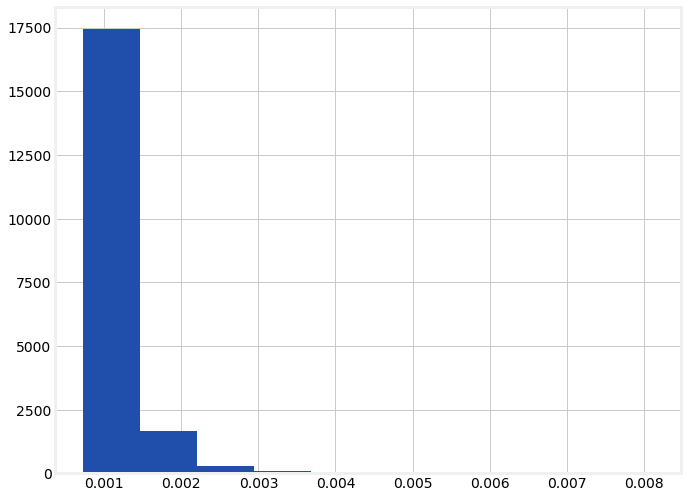

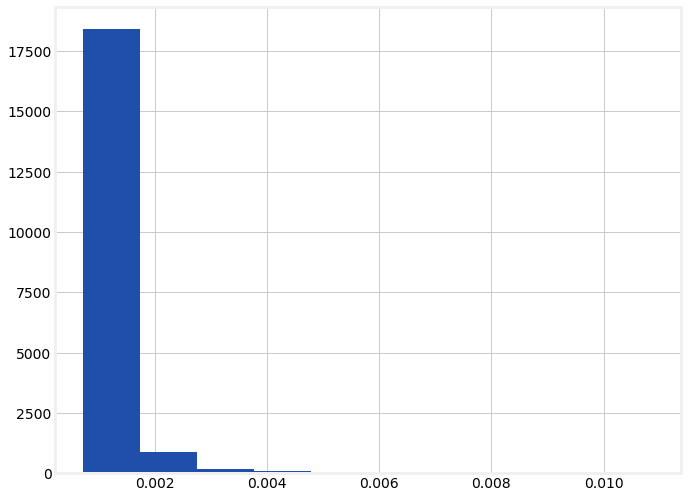

In [7]:
# sanity check
plt.hist(row_time)
plt.show();

plt.hist(df_time)
plt.show();

In [8]:
# putting the results into df to make it easier for me

row_results= pd.DataFrame([('row_time', time) for time in row_time])
df_results= pd.DataFrame([('df_time', time) for time in df_time])
results_df = pd.concat([row_results, df_results], axis=0)
results_df.rename(columns={
    0:'group_name'
    , 1: 'time'
}, inplace=True)


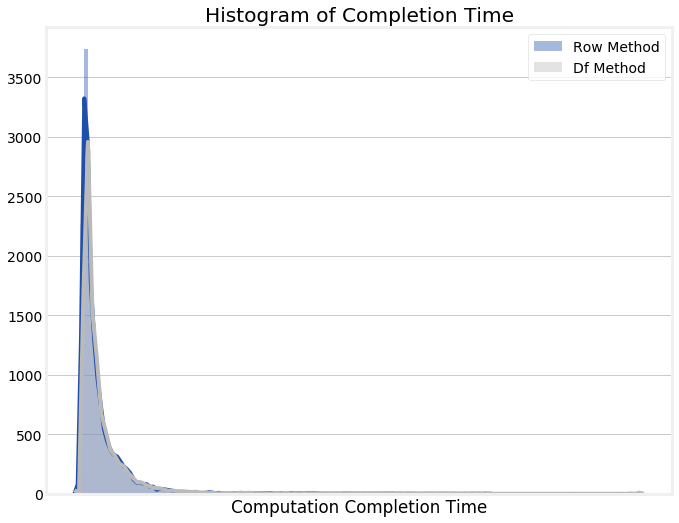

In [9]:
# plotting the data

sns.distplot(results_df[results_df['group_name'] == 'row_time']['time'], bins=100, label='Row Method')
sns.distplot(results_df[results_df['group_name'] == 'df_time']['time'], bins=100, label='Df Method')

plt.xticks([])
plt.xlabel('Computation Completion Time')
plt.legend()
plt.title('Histogram of Completion Time')

plt.show();

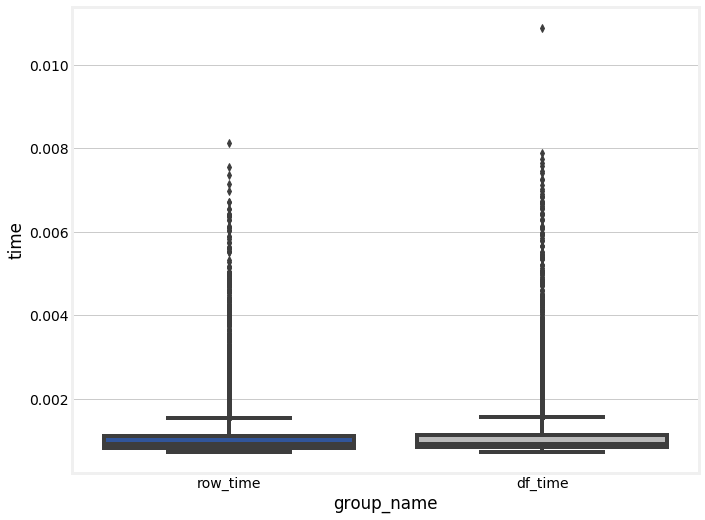

In [10]:
sns.boxplot(data=results_df
           , x='group_name'
           , y='time');

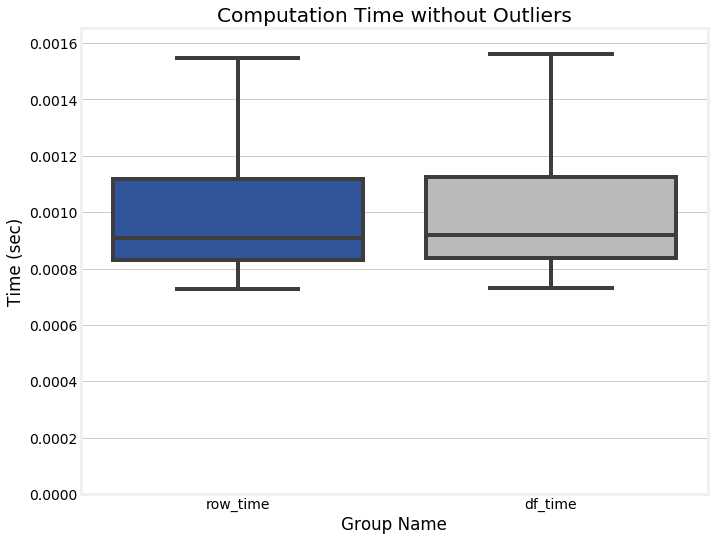

In [11]:
sns.boxplot(data=results_df
           , x='group_name'
           , y='time'
           , fliersize=0 # removing the outliers to make a cleaner graph but acknowledged this step
           )

# make it zoomed it to the highest whisker (1.5STD)
biggest_whisker_value = max(
    np.median(results_df[results_df.group_name == 'row_time']['time']) + 1.5*(np.quantile(results_df[results_df.group_name == 'row_time']['time'], .75) - np.quantile(results_df[results_df.group_name == 'row_time']['time'], .25))
    ,np.median(results_df[results_df.group_name == 'df_time']['time']) + 1.5*(np.quantile(results_df[results_df.group_name == 'df_time']['time'], .75) - np.quantile(results_df[results_df.group_name == 'df_time']['time'], .25))
)

plt.ylim(0
    , biggest_whisker_value + 0.0003)# should probably not make it hard coded and make it one knotch above for aes

plt.title('Computation Time without Outliers')
plt.ylabel('Time (sec)')
plt.xlabel('Group Name')

plt.savefig('assets/Boxplot.svg')
plt.show();


## 2-Sample T-test

Because we violated one of the assumptions for a t-test (data from normal distribution), we cannot use a parametric test. Instead, we can opt for a non-parametric test like the Mann-Whitney U test.

### 2-sample independent t-test assumptions (3)
1. independence
    - 2 independent, categorical variables
2. normality
    - the dependent (continuous) variable should be approximately normally distributed
3. homogenous variance
    - the variance of the two groups should be approximately equals
    
When these assumptions are not satisfied, then we cannot use parametric tests since they rely on these assumptions. Instead, we can use non-parametric tests which do not make assumptions about the data distribution.

### We can use Quantile-Quantile (QQ) plots to determine if a distribution is normal


This is a quick and dirty visual check. But you can imagine that this is insufficient when we have more ambiguous data. 

To be thorough and precise, we can employ more quantitative approaches to check for normality.

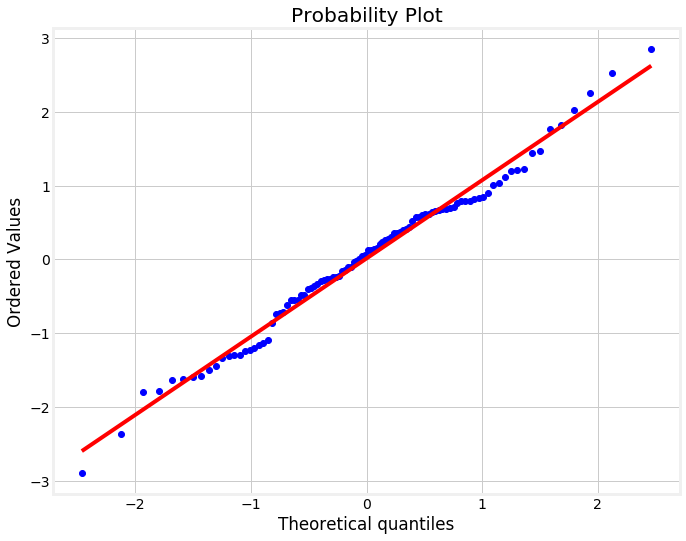

In [12]:
# what does it look like with normally distributed data?

normal_data = np.random.normal(size=100)
stats.probplot(normal_data, dist='norm', plot=plt);

plt.savefig('assets/Normal_QQ_Plot.svg')

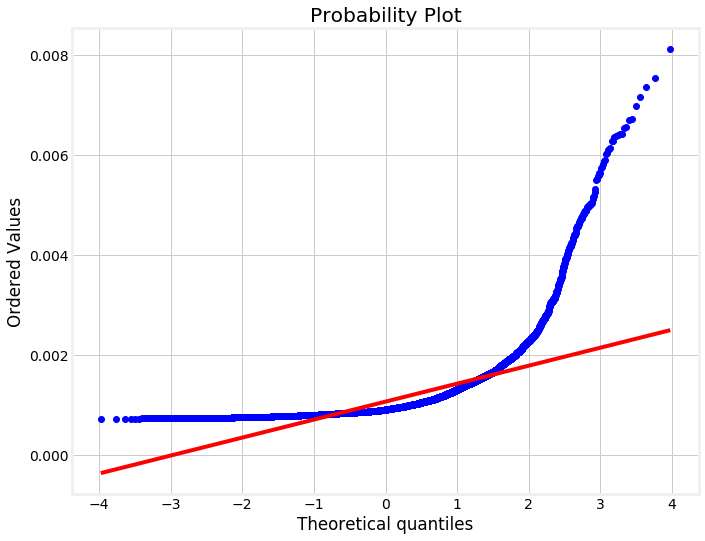

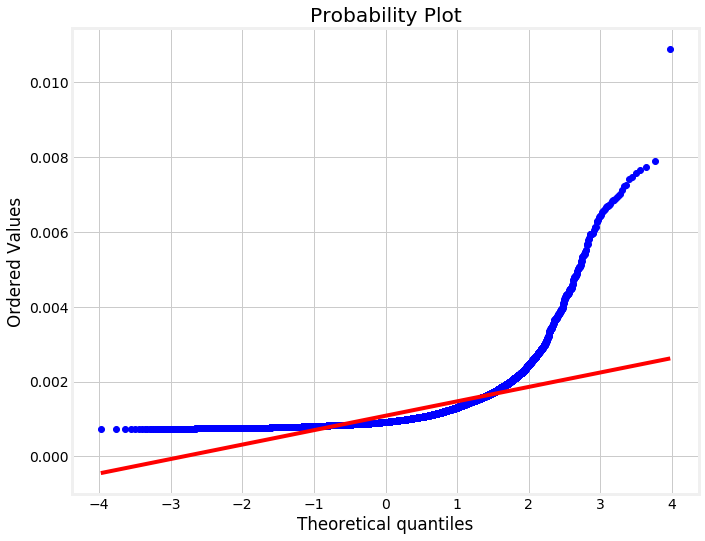

In [13]:
# visual test of normality just for kicks and giggles

stats.probplot(row_time
               , dist="norm"
               , plot=plt);
plt.show();

stats.probplot(df_time
               , dist="norm"
               , plot=plt);

plt.savefig('assets/Not_Normal_QQ_Plot.svg')

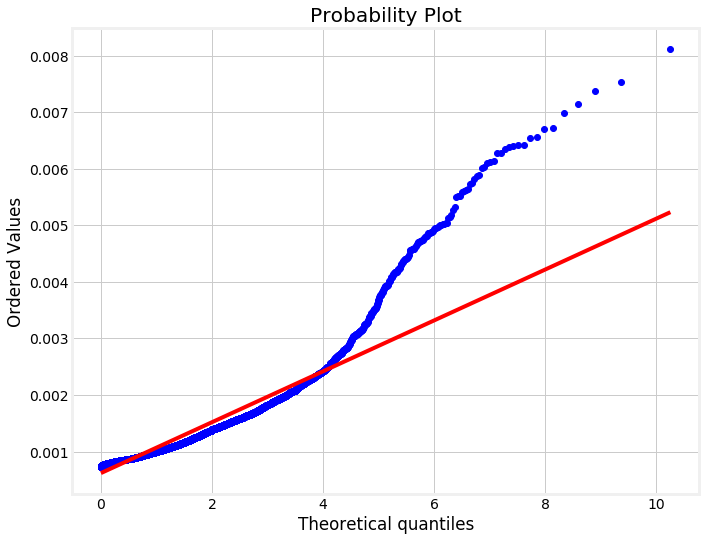

In [14]:
# just for funsies lets see how well it fits the gamma distribution so we know what kind of distribution this is

a = 1
stats.probplot(row_time, dist=stats.gamma(a), plot=plt);

Since it clearly does not comply with the normality assumption, we cannot use parametric tests due to the increased risk of false positives. We can, however, use non-parametric tests since they don't make assumptions about the data distribution.

Instead of the 2-sample t-test, we can use the Mann-Whitney U Test which is the non-parametric equivalent.

In [15]:
# sanity check
len(row_time), len(df_time)

(19604, 19642)

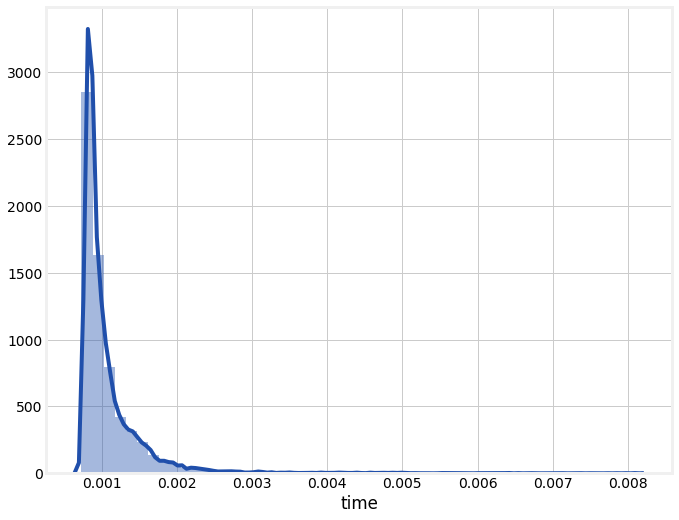

In [16]:
# sanity check
sns.distplot(results_df[results_df.group_name == 'row_time']['time']);

In [17]:
U_stat, p_value = stats.mannwhitneyu(row_time, df_time)
p_value = round(p_value, 2)

if p_value > critical_p:
    print(f'With a p_value of {p_value}, we fail to reject the null hypothesis')
else:
    print(f'With a p_value of {p_value}, we reject the null hypothesis')


With a p_value of 0.0, we reject the null hypothesis


The results from the Mann-Whitney U-test are in the context of the _distributions,_  but cannot be used to quantify the effect that it recognizes in terms of statistics (like the mean, median, or variance). To get more granular data, we can employ computational methods.

## Significance Testing with Fischer's Permutation Tests 
#### Non-Parametric Approach for Non-Normal Data

Non-parametric test:
- builds null distribution to use for hypothesis testing by rearranging the samples without replacement and calculating the test statistic given that the H<sub>0</sub> is true aka no difference between the two groups
- compares the observed statistic to the one given 

Permutation Tests are _Exact_ tests, which means greater accuracy.

Assumptions:
- independent samples
- exchangable samples

### We reject the H<sub>0</sub> that there is no difference in computation completion time between the two methods.

However, more steps needed to further analyze this data:
- estimating the difference in computation time with non-parametric bootstrap by modeling the H<sub>0</sub> hypothesis and compute the test statistic

In [18]:
permutation_dataset = results_df.copy(deep=True) # just in case since the permutations shuffle the results

In [19]:

num_permutations = 1000

perm_mean_results = []
perm_median_difference = []
perm_var_difference = []

for _ in range(num_permutations):
    
    # permutation test done without replacement
    permutation_dataset['time'] = np.random.permutation(permutation_dataset['time'])
    
    row_results = permutation_dataset[permutation_dataset.group_name=='row_time']
    df_results = permutation_dataset[permutation_dataset.group_name=='df_time']
    
    perm_mean_results.append(np.mean(row_results['time']) 
                             - np.mean(df_results['time'])
                            )
    
    perm_median_difference.append(np.median(row_results['time']) 
                         - np.median(df_results['time'])
                        )
    
    perm_var_difference.append((np.std(row_results['time'])**2) 
                               - (np.std(df_results['time'])**2)
                              )

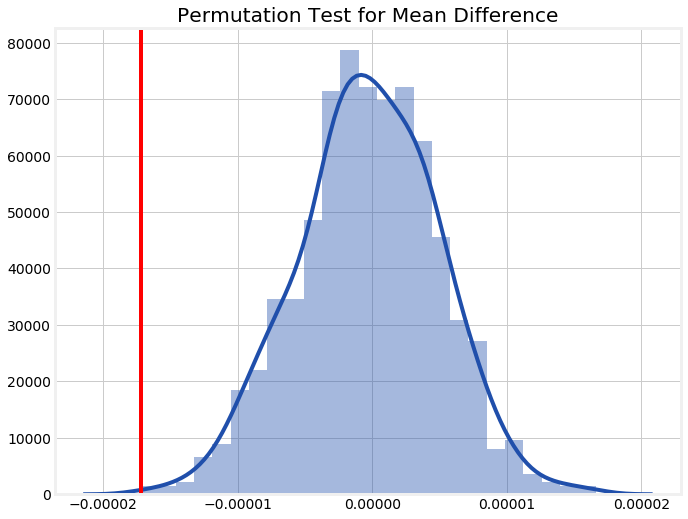

0.001
With a p-value of 0.001, we reject the null hypothesis that the means are different


In [20]:
observed_difference = (np.mean(results_df[results_df.group_name == 'row_time']['time']) 
                       - np.mean(results_df[results_df.group_name == 'df_time']['time']))

sns.distplot(perm_mean_results)

plt.axvline(observed_difference
            , color='r'
            , label='observed difference')
plt.ticklabel_format(style='plain', axis='x')
# plt.xticks([np.mean(perm_mean_results), observed_difference])
plt.ticklabel_format(style='sci', axis='x')
plt.title('Permutation Test for Mean Difference')

plt.savefig('assets/Permutation_Mean.svg')

plt.show();


# calculating the p-value for two-tailed hypothesis test

p_value = sum(np.abs(perm_mean_results) >= np.abs(observed_difference))/len(perm_mean_results)
print(p_value)
if p_value > 0.05:
    print(f'With a p-value of {p_value}, we fail to reject the null hypothesis')
else:
    print(f'With a p-value of {p_value}, we reject the null hypothesis that the means are different')


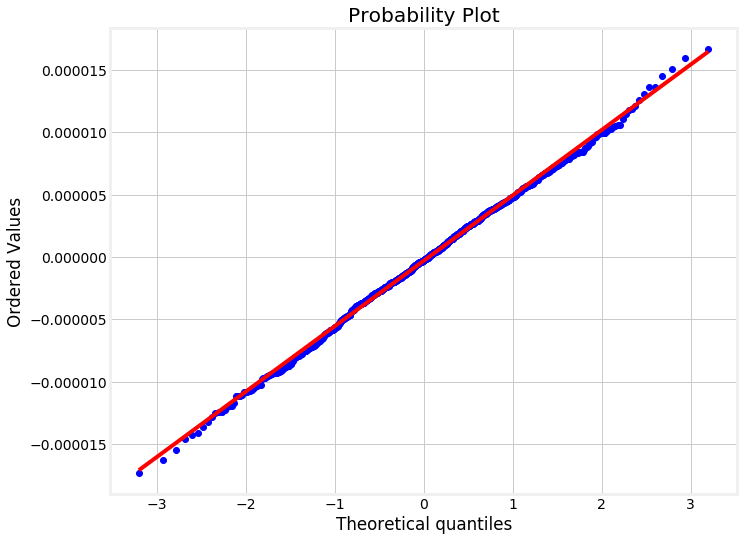

In [21]:
stats.probplot(perm_mean_results, dist='norm', plot=plt)
plt.show();

1000


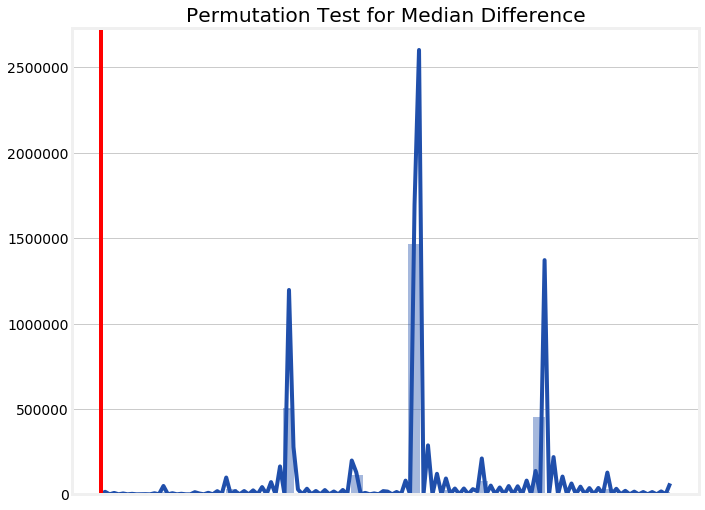

0.0
With a p-value of 0.0, we reject the null hypothesis that there is no difference in medians


In [22]:
observed_median_difference = (np.median(results_df[results_df.group_name == 'row_time']['time']) 
                       - np.median(results_df[results_df.group_name == 'df_time']['time']))

print(len(perm_median_difference))
sns.distplot(perm_median_difference)

plt.axvline(observed_median_difference
            , color='r'
            , label='observed difference')
plt.xticks([])
plt.title("Permutation Test for Median Difference")

plt.savefig('assets/Permutation_Median.svg')
plt.show();


# calculating the p-value for two-tailed hypothesis test

p_value = sum(np.abs(perm_median_difference) >= np.abs(observed_median_difference))/len(perm_median_difference)
print(p_value)
if p_value > critical_p:
    print(f'With a p-value of {p_value}, we fail to reject the null hypothesis')
else:
    print(f'With a p-value of {p_value}, we reject the null hypothesis that there is no difference in medians')

Technically, a correction needs to be applied here to combat the increased risk of false positives. We can apply the bonferroni correction and divide the crtical p-value by the number of statistical analysis performed.

In [23]:
# bonferroni correction
if p_value > critical_p/2:
    print(f'With a p-value of {p_value}, we fail to reject the null hypothesis')
else:
    print(f'With a p-value of {p_value}, we reject the null hypothesis that there is no difference in medians')

With a p-value of 0.0, we reject the null hypothesis that there is no difference in medians


We can also test to see if there is a statistically significant different variance in the two distributions

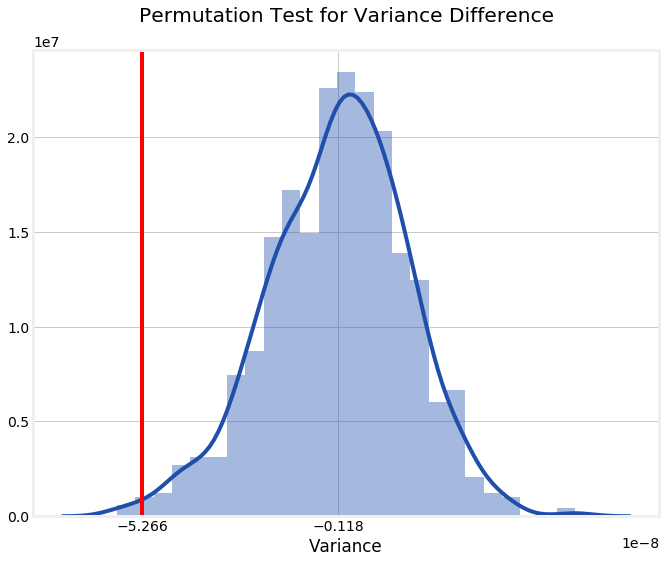

1000


In [24]:
sns.distplot(perm_var_difference)

observed_std_difference = (np.std(results_df[results_df.group_name=='row_time']['time'])**2 
                           - np.std(results_df[results_df.group_name == 'df_time']['time'])**2) # variance is the square of std
plt.axvline(observed_std_difference, color='r')
plt.xticks([np.mean(perm_var_difference), observed_std_difference])
plt.title('Permutation Test for Variance Difference\n')
plt.xlabel('Variance')

plt.savefig('assets/Permutation_Variance.svg')
plt.show();

print(len(perm_var_difference))

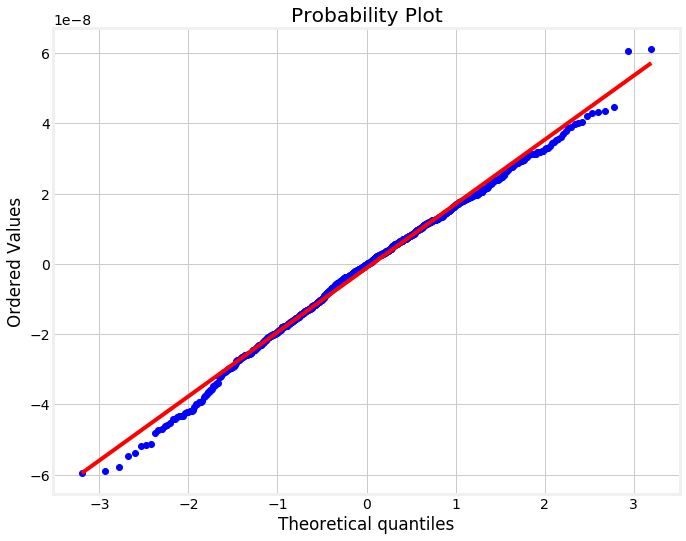

In [25]:
stats.probplot(perm_var_difference, dist='norm', plot=plt)
plt.show();

In [26]:
p_value = sum(np.abs(perm_var_difference) >= np.abs(observed_std_difference)) / len(perm_var_difference)
p_value = round(p_value, 2)
if p_value > critical_p:
    print(f'With a p-value of {p_value}, we fail to reject the null hypothesis')
else:
    print(f'With a p-value of {p_value}, we reject the null hypothesis')

With a p-value of 0.01, we reject the null hypothesis


## Bootstrapped Non-parametric Means

Because we have a non-normal distribution, we are able to rely on a tenant of the Central Limit Theorem and bootstrap to get more normal results. 

However, we can continue the analysis by utilizing the Law of Large Numbers and computational approaches in statistics.

By bootstrapping, we are utilizing the law which states that the mean of samples taken from non-normal distributions follow a normal distribution.

We are assuming that the variance we see in the dataset is representative of the variance in the null distribution, therefore bootstrapping results would be representative of taking random samples from the null distribution.

For permutation tests, in theory you're supposed to conduct it with the maximum number of permutations. However, due to the Central Limit Theorem, we are able to truncate the number of sufficient permutations to approximate the permutation distribution. 

In [27]:
num_sim = 1000 # check why UW recommends starting at 1000 without taking into account power analysis results

Bootstrap Results

In [28]:
bootstrapped_row_mean = []
bootstrapped_df_mean = []

bootstrapped_row_median = []
bootstrapped_df_median = []


for _ in range(num_sim):
    # sample with replacement
    bootstrapped_row = np.random.choice(row_time, len(row_time))
    bootstrapped_df = np.random.choice(df_time, len(df_time))
    
    bootstrapped_row_median.append(np.median(bootstrapped_row))
    bootstrapped_df_median.append(np.median(bootstrapped_df))
    
    bootstrapped_row_mean.append(np.mean(bootstrapped_row))
    bootstrapped_df_mean.append(np.mean(bootstrapped_df))

    
len(bootstrapped_row_median), len(bootstrapped_df_median)

(1000, 1000)

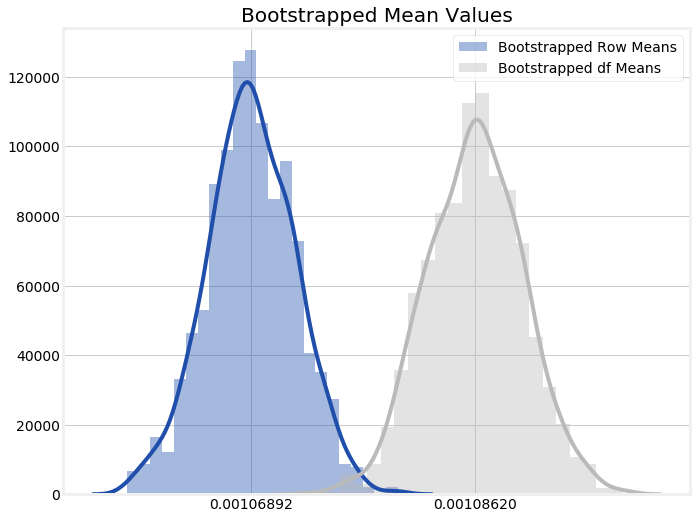

In [29]:
# plotting results

sns.distplot(bootstrapped_row_mean, label='Bootstrapped Row Means')
sns.distplot(bootstrapped_df_mean, label='Bootstrapped df Means') # MLE instead
plt.legend()

plt.xticks([np.mean(bootstrapped_row_mean), np.mean(bootstrapped_df_mean)]) 
# removed the x-axis bc it doesnt provide additional information and just clutters the graph
# i should change the magnitude to scientific notation to make it cleaner
plt.title('Bootstrapped Mean Values')
plt.savefig('assets/Bootstrap_Mean.svg')
plt.show();

Recall that the confidence interval is comprised of the mean, and the standard error (std/ sqrt(n)).

Also recall what the confidence interval represents. Because we arrived at our data from simulations, we are able to computatational determine the confidence interval instead of the usual analytical methods.

In [30]:
# confidence interval for the difference in computation time
cm = sms.CompareMeans(sms.DescrStatsW(bootstrapped_df_mean), sms.DescrStatsW(bootstrapped_row_mean))
lower_bound, upper_bound = cm.tconfint_diff(usevar='unequal') / np.mean(bootstrapped_df_mean) * 100

print(f'''
Our 95% confidence interval finds a {round(lower_bound, 2)}% to {round(upper_bound, 2)}% mean reduction in computation time.
''')


Our 95% confidence interval finds a 1.56% to 1.62% mean reduction in computation time.



In [31]:
# calculating the 95 confidence interval for the row method

np.quantile(bootstrapped_row_mean, .025), np.quantile(bootstrapped_row_mean, .975)

(0.001061949063966543, 0.0010753447000612418)

In [32]:
# calculating the 95 confidence interval for the df method

np.quantile(bootstrapped_df_mean, .025), np.quantile(bootstrapped_df_mean, .975)

(0.0010792162330720096, 0.00109340076112413)

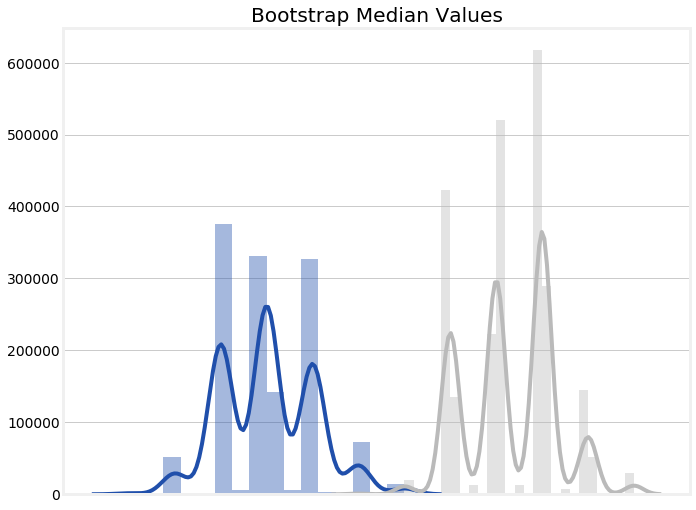

In [33]:
sns.distplot(bootstrapped_row_median)
sns.distplot(bootstrapped_df_median)

plt.xticks([])

plt.title('Bootstrap Median Values')
plt.savefig('assets/Bootstrap_Median.svg')
plt.show();

In [34]:
# confidence interval for the difference in computation time
cm = sms.CompareMeans(sms.DescrStatsW(bootstrapped_df_median), sms.DescrStatsW(bootstrapped_row_median))
lower_bound, upper_bound = cm.tconfint_diff(usevar='unequal') / np.mean(bootstrapped_df_median) * 100

print(f'''
Our 95% confidence interval finds a {round(lower_bound, 2)}% to {round(upper_bound, 2)}% median reduction in computation time.
''')


Our 95% confidence interval finds a 1.13% to 1.17% median reduction in computation time.



# Key Takeaways:

- data transformations should be performed on specified columns instead of passing dataframes into functions
- depending on the business significance of the reduction of resources, it may or may not be helpful to change previous infrastructure to act on this insight
- depending on the business's tolerance for false positives (thinking there is a difference in computation time when in reality there isn't, and the results we see are due to chance), you may decide to act on this insight

## _Statistical_ Significance v _Practical_ Significance

It is important to note and acknowledge the difference between statistical and practical significance--just because something is _statistically_ significant doesn't mean that it is _practically_ significant.

In this context, we've established that we have evidence to rejec the H<sub>0</sub>. However, we find that the 95% confidence interval for the reduction in computation time is about 1%. This needs to be applied in the business context--we need to weigh the time and resource investment necessary to reap the reduction in computation time and resource budget.

<mark>Depending on the cost-benefit analysis, it could be practically signficant or not, and the final recommendation given the results of the analysis.</mark>

## Future Analysis:

- do different types of functions being applied to data frames affect the performance and the difference we can expect?
- does the length of the dataframe influence the difference between methods?
- does the complexity of the function (increasing baseline computation time) affect the difference between methods?
- is there a difference in the data types and their effect on performance?

References:
- [setting random_seed for numpy](https://www.sharpsightlabs.com/blog/numpy-random-seed/)
- [normal distribution and ANOVA tests](https://stats.stackexchange.com/questions/5680/can-i-trust-anova-results-for-a-non-normally-distributed-dv)
- [interpreting ANOVA results](https://statistics.laerd.com/spss-tutorials/one-way-anova-using-spss-statistics-2.php)